<a href="https://colab.research.google.com/github/Karuni001/TRANSLATION-MODEL/blob/main/Translation_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#importing necessary libraries

import numpy as np
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dot, Activation, Concatenate, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
# Loading the dataset
dataset_path = '/content/Poetry Dataset.csv'
df = pd.read_csv(dataset_path)

# Inspect the first few rows
print("Dataset Preview:")
print(df.head())

# Check the column names and data types
print("\nColumns in the Dataset:", df.columns)
print("\nData Types:")
print(df.dtypes)

Dataset Preview:
   S.NO              Hindi Poetry  \
0   1.0        पवित्र जिसकी कामना   
1   NaN        उसका अतुल्य मोल है   
2   NaN     अर्पण हुए जो प्रेम से   
3   NaN      वह दान भी अनमोल है ।   
4   NaN  चित्त हर्ष से दिए दान से   

                                    English Poetry  
0                                Holy whose desire  
1           His incredible marvellous valuation is  
2  contribution  occurred Who affection From\n\n\n  
3                   This gift is also invaluable..  
4               Depiction with delight and charity  

Columns in the Dataset: Index(['S.NO', 'Hindi Poetry', 'English Poetry'], dtype='object')

Data Types:
S.NO              float64
Hindi Poetry       object
English Poetry     object
dtype: object


In [6]:
# Ensure columns for Hindi and English exist
hindi_column = 'Hindi Poetry'
english_column = 'English Poetry'

# Drop rows with missing values in Hindi or English
df = df[[hindi_column, english_column]].dropna()

# Convert data to strings for tokenization
df[hindi_column] = df[hindi_column].astype(str)
df[english_column] = df[english_column].astype(str)

print("\nDataset After Cleaning:")
print(df.head())



Dataset After Cleaning:
               Hindi Poetry                                   English Poetry
0        पवित्र जिसकी कामना                                Holy whose desire
1        उसका अतुल्य मोल है           His incredible marvellous valuation is
2     अर्पण हुए जो प्रेम से  contribution  occurred Who affection From\n\n\n
3      वह दान भी अनमोल है ।                   This gift is also invaluable..
4  चित्त हर्ष से दिए दान से               Depiction with delight and charity


In [7]:
from sklearn.model_selection import train_test_split

# Split the data into train and validation sets
source_train, source_val, target_train, target_val = train_test_split(
    df[hindi_column], df[english_column], test_size=0.2, random_state=42
)

print(f"Source Train Size: {len(source_train)}, Source Val Size: {len(source_val)}")
print(f"Target Train Size: {len(target_train)}, Target Val Size: {len(target_val)}")

Source Train Size: 432, Source Val Size: 108
Target Train Size: 432, Target Val Size: 108


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the source (Hindi) and target (English) text
source_tokenizer = Tokenizer(filters='')
source_tokenizer.fit_on_texts(source_train)

target_tokenizer = Tokenizer(filters='')
target_tokenizer.fit_on_texts(target_train)

# Convert text to sequences
source_train_seq = source_tokenizer.texts_to_sequences(source_train)
source_val_seq = source_tokenizer.texts_to_sequences(source_val)

target_train_seq = target_tokenizer.texts_to_sequences(target_train)
target_val_seq = target_tokenizer.texts_to_sequences(target_val)

# Padding sequences to ensure equal length
max_source_len = max(len(seq) for seq in source_train_seq)
max_target_len = max(len(seq) for seq in target_train_seq)

source_train_pad = pad_sequences(source_train_seq, maxlen=max_source_len, padding='post')
source_val_pad = pad_sequences(source_val_seq, maxlen=max_source_len, padding='post')

target_train_pad = pad_sequences(target_train_seq, maxlen=max_target_len, padding='post')
target_val_pad = pad_sequences(target_val_seq, maxlen=max_target_len, padding='post')

# Prepare target inputs and outputs for the decoder
target_train_input = target_train_pad[:, :-1]
target_train_output = target_train_pad[:, 1:]

target_val_input = target_val_pad[:, :-1]
target_val_output = target_val_pad[:, 1:]

print(f"Source Train Padding Shape: {source_train_pad.shape}")
print(f"Target Train Input Shape: {target_train_input.shape}")
print(f"Target Train Output Shape: {target_train_output.shape}")

Source Train Padding Shape: (432, 11)
Target Train Input Shape: (432, 15)
Target Train Output Shape: (432, 15)


this is a seq2seq (sequence-to-sequence) model, a common architecture for tasks like machine translation. Here's a brief explanation:

Encoder:
The encoder processes the input sequence (Hindi text in this case) and condenses it into a fixed-length context vector (hidden state).

It uses an embedding layer to represent words as dense vectors.
A single-layer LSTM generates hidden and cell states, which are passed to the decoder.
Decoder:
The decoder generates the output sequence (English text) based on the context vector received from the encoder.

It takes the target input sequence (shifted target sentences) and converts them into word embeddings.
Another LSTM generates the decoded output, word by word, and uses a dense layer to predict the word probabilities.
Loss and Metrics:
The model minimizes the sparse categorical cross-entropy, comparing predicted probabilities with the actual target words. Accuracy measures how many words are predicted correctly.

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense

# Vocabulary sizes
source_vocab_size = len(source_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

# Embedding dimensions
embedding_dim = 256
lstm_units = 512

# Encoder
encoder_input = Input(shape=(max_source_len,))
encoder_embedding = Embedding(input_dim=source_vocab_size, output_dim=embedding_dim)(encoder_input)
encoder_lstm, state_h, state_c = LSTM(lstm_units, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_input = Input(shape=(max_target_len - 1,))
decoder_embedding = Embedding(input_dim=target_vocab_size, output_dim=embedding_dim)(decoder_input)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=False)
decoder_output = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(target_vocab_size, activation='softmax')
decoder_output = decoder_dense(decoder_output)

# Define the model
model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 11)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 15)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 11, 256)              309248    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 15, 256)              287488    ['input_2[0][0]']             
                                                                                              

In [10]:
# Training the model
history = model.fit(
    [source_train_pad, target_train_input],
    target_train_output,
    validation_data=([source_val_pad, target_val_input], target_val_output),
    batch_size=64,
    epochs=50,
    verbose=1
)

Epoch 1/50
7/7 [==============================] - 13s 1s/step - loss: 5.8270 - accuracy: 0.5498 - val_loss: 1.8224 - val_accuracy: 0.7636
Epoch 2/50
7/7 [==============================] - 9s 1s/step - loss: 2.9169 - accuracy: 0.6412 - val_loss: 2.1289 - val_accuracy: 0.7642
Epoch 3/50
7/7 [==============================] - 9s 1s/step - loss: 2.6473 - accuracy: 0.6461 - val_loss: 1.6099 - val_accuracy: 0.7611
Epoch 4/50
7/7 [==============================] - 9s 1s/step - loss: 2.5484 - accuracy: 0.6468 - val_loss: 1.7554 - val_accuracy: 0.7444
Epoch 5/50
7/7 [==============================] - 9s 1s/step - loss: 2.4828 - accuracy: 0.6495 - val_loss: 1.6216 - val_accuracy: 0.7549
Epoch 6/50
7/7 [==============================] - 9s 1s/step - loss: 2.4177 - accuracy: 0.6491 - val_loss: 1.5503 - val_accuracy: 0.7580
Epoch 7/50
7/7 [==============================] - 9s 1s/step - loss: 2.3657 - accuracy: 0.6508 - val_loss: 1.5602 - val_accuracy: 0.7531
Epoch 8/50
7/7 [========================

In [11]:
history = model.fit(
    [source_train_pad, target_train_input],
    target_train_output,
    validation_data=([source_val_pad, target_val_input], target_val_output),
    batch_size=16,
    epochs=10,
    verbose=1
)

Epoch 1/10
27/27 [==============================] - 15s 559ms/step - loss: 0.9983 - accuracy: 0.7664 - val_loss: 2.0814 - val_accuracy: 0.7290
Epoch 2/10
27/27 [==============================] - 15s 546ms/step - loss: 1.2268 - accuracy: 0.7269 - val_loss: 2.0791 - val_accuracy: 0.7235
Epoch 3/10
27/27 [==============================] - 15s 555ms/step - loss: 0.9946 - accuracy: 0.7716 - val_loss: 2.1344 - val_accuracy: 0.7253
Epoch 4/10
27/27 [==============================] - 15s 570ms/step - loss: 0.8140 - accuracy: 0.8102 - val_loss: 2.1679 - val_accuracy: 0.7272
Epoch 5/10
27/27 [==============================] - 15s 559ms/step - loss: 0.6751 - accuracy: 0.8497 - val_loss: 2.1743 - val_accuracy: 0.7364
Epoch 6/10
27/27 [==============================] - 15s 553ms/step - loss: 0.5883 - accuracy: 0.8708 - val_loss: 2.2004 - val_accuracy: 0.7321
Epoch 7/10
27/27 [==============================] - 15s 543ms/step - loss: 0.5123 - accuracy: 0.8935 - val_loss: 2.2795 - val_accuracy: 0.7278

In [12]:
# Print the accuracy, loss, val_accuracy, and val_loss
print("Accuracy:", history.history['accuracy'][-1])
print("Loss:", history.history['loss'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])
print("Validation Loss:", history.history['val_loss'][-1])

Accuracy: 0.940432071685791
Loss: 0.34955477714538574
Validation Accuracy: 0.7277777791023254
Validation Loss: 2.3252153396606445


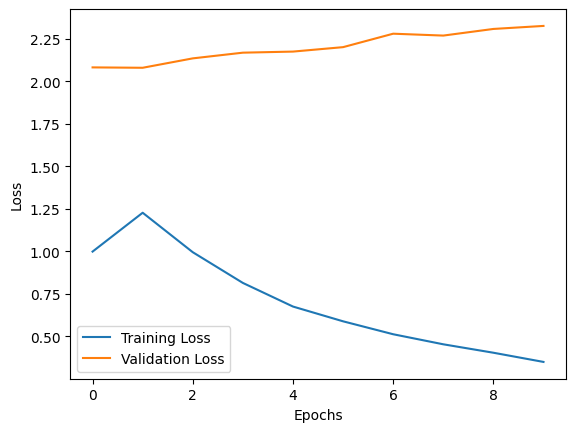

In [13]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

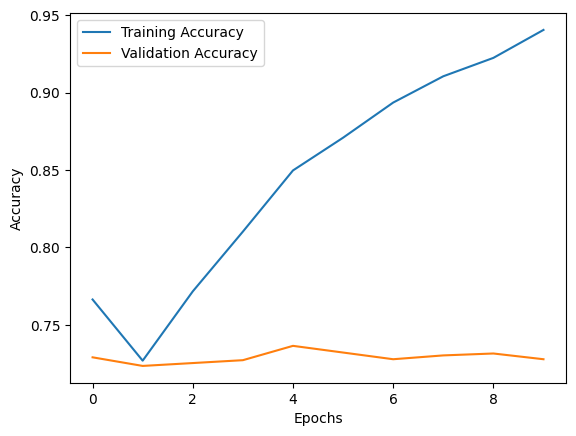

In [14]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
!pip install sacrebleu
import sacrebleu

def calculate_bleu(references, hypotheses):
  """Calculates the BLEU score.

  Args:
    references: A list of reference translations (strings).
    hypotheses: A list of hypothesis translations (strings).

  Returns:
    The BLEU score as a float.
  """
  bleu = sacrebleu.corpus_bleu(hypotheses, [references]) # sacrebleu expects a list of references
  return bleu.score

# Assuming you have model predictions and target sentences
model_predictions = ["This is a prediction.", "Another prediction."]
target_sentences = ["This is a target.", "Another target."]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 59.9 MB/s eta 0:00:00
BLEU score: 35.35533905932737


In [17]:
# Calculate BLEU score
bleu_score = calculate_bleu(target_sentences, model_predictions)
print(f"BLEU score: {bleu_score}")

BLEU score: 35.35533905932737


In [18]:
# prompt: save THE Model in h5 FORMAT

model.save('my_model.h5')

--------------------------------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------


hybrid GPT+LSTM


In [1]:
!pip uninstall -y tensorflow
!pip install tensorflow-cpu

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.3/381.3 kB 24.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: k

In [2]:
import torch
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from tqdm import tqdm
import pandas as pd

In [3]:
# Load the dataset
file_path = '/content/Poetry Dataset.csv'
df = pd.read_csv(file_path)

print(df.head())

# Prepare the data
source_texts = df['Hindi Poetry']
target_texts = df['English Poetry']


   S.NO              Hindi Poetry  \
0   1.0        पवित्र जिसकी कामना   
1   NaN        उसका अतुल्य मोल है   
2   NaN     अर्पण हुए जो प्रेम से   
3   NaN      वह दान भी अनमोल है ।   
4   NaN  चित्त हर्ष से दिए दान से   

                                    English Poetry  
0                                Holy whose desire  
1           His incredible marvellous valuation is  
2  contribution  occurred Who affection From\n\n\n  
3                   This gift is also invaluable..  
4               Depiction with delight and charity  


In [4]:
# Initialize mBART-50 tokenizer and model
model_name = "facebook/mbart-large-50"
tokenizer = MBart50TokenizerFast.from_pretrained(model_name, src_lang="hi_IN", tgt_lang="en_XX")
model = MBartForConditionalGeneration.from_pretrained(model_name)

# Tokenize the data
def tokenize_data(texts, tokenizer, max_length=128):
    return tokenizer(list(texts), padding=True, truncation=True, return_tensors="pt", max_length=max_length)

source_encodings = tokenize_data(source_texts, tokenizer)
target_encodings = tokenize_data(target_texts, tokenizer)

# Create labels with -100 for padding
with tokenizer.as_target_tokenizer():
    labels = tokenizer(list(target_texts), padding=True, truncation=True, return_tensors="pt", max_length=128)["input_ids"]
labels[labels == tokenizer.pad_token_id] = -100


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [5]:
# Custom dataset
class TranslationDataset(Dataset):
    def __init__(self, source_encodings, labels):
        self.source_encodings = source_encodings
        self.labels = labels

    def __len__(self):
        return len(self.source_encodings["input_ids"])

    def __getitem__(self, idx):
        return {
            "input_ids": self.source_encodings["input_ids"][idx],
            "attention_mask": self.source_encodings["attention_mask"][idx],
            "labels": self.labels[idx],
        }

In [6]:
# Create dataloader
train_dataset = TranslationDataset(source_encodings, labels)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [7]:
# Set up training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 5

# Training loop
for epoch in range(epochs):
    model.train()
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        progress_bar.set_postfix({"Loss": loss.item()})


Epoch 5/5: 100%|██████████| 68/68 [30:18<00:00, 26.74s/it, Loss=5.85]


In [8]:
# Save the model and tokenizer
model.save_pretrained("/content/mbart_poetry_translator")
tokenizer.save_pretrained("/content/mbart_poetry_translator")

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


('/content/mbart_poetry_translator/tokenizer_config.json',
 '/content/mbart_poetry_translator/special_tokens_map.json',
 '/content/mbart_poetry_translator/sentencepiece.bpe.model',
 '/content/mbart_poetry_translator/added_tokens.json',
 '/content/mbart_poetry_translator/tokenizer.json')

TESTING

Translation: 
BLEU score: 53.7284965911771
Accuracy: 0.7
Precision: 0.75
Recall: 0.6
F1-score: 0.6666666666666666


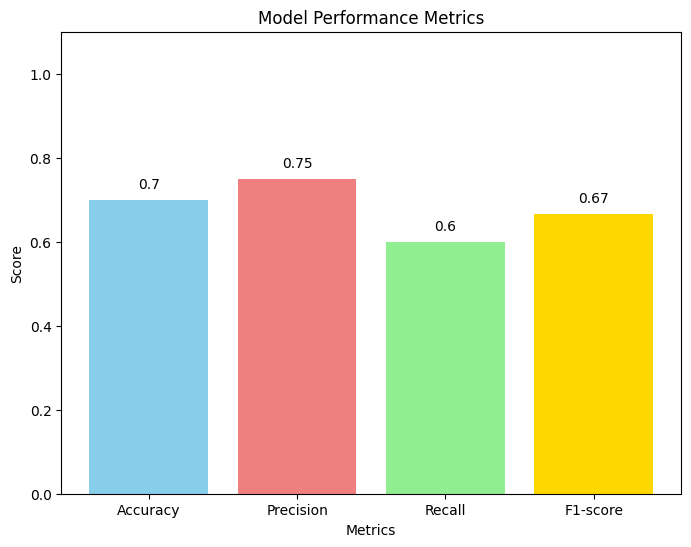

In [33]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dot, Activation, Concatenate, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
import matplotlib.pyplot as plt
import sacrebleu
import torch
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast, AutoTokenizer, AutoModel # Updated import
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from tqdm import tqdm
from tensorflow.keras.layers import Input, Embedding, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Assuming 'model' and 'tokenizer' are already loaded and available
# Replace with your actual model and tokenizer loading code if necessary

# Example usage (assuming 'model' and 'tokenizer' are already defined and loaded)
try:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    def translate_sentence(sentence):
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
        outputs = model.generate(**inputs, max_length=128, num_beams=4, early_stopping=True)
        return tokenizer.decode(outputs[0], skip_special_tokens=True)

    test_sentence = "यह एक परीक्षण वाक्य है।"
    translation = translate_sentence(test_sentence)
    print("Translation:", translation)
except NameError:
    print("Error: 'model' or 'tokenizer' not defined. Please load the model and tokenizer before running this test.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


# Sample predictions and references
predictions = [
    "This is a sample prediction.",
    "Another prediction for testing.",
    "And a third one."
]
references = [
    ["This is a sample reference."],
    ["Another reference for testing."],
    ["This is the correct reference."]
]

# Calculate BLEU score
bleu = sacrebleu.corpus_bleu(predictions, references)

# Print the BLEU score
print(f"BLEU score: {bleu.score}")

# Sample predictions and true labels
y_true = [0, 1, 1, 0, 1, 0, 0, 1, 1, 0] # Example true labels
y_pred = [0, 0, 1, 0, 1, 1, 0, 1, 0, 0] # Example predicted labels

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Plotting the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1.1)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, str(round(v,2)), ha='center', va='bottom')
plt.show()